# LEVEL 10 - EDA

In [33]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action="ignore")

In [34]:
# Load CSV file into a pandas DataFrame
file_path = "./data/train_data.csv"
data = pd.read_csv(file_path)
# Removing wrong values
data.dropna(inplace=True)
data = data[data['AMPS'].between(0, 1)]
data['UNIT'][data['TEMP']>100] = 'K'
data['UNIT'][data['TEMP']<100] = 'C'
data['TEMP'][data['TEMP']>100] = data['TEMP'][data['TEMP']>100] - 273.25
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MODE    971 non-null    object 
 1   POWER   971 non-null    object 
 2   AMPS    971 non-null    float64
 3   VOLTS   971 non-null    float64
 4   TEMP    971 non-null    float64
 5   UNIT    971 non-null    object 
 6   DELTA   971 non-null    float64
 7   GAMMA   971 non-null    float64
 8   OUTPUT  971 non-null    float64
dtypes: float64(6), object(3)
memory usage: 68.4+ KB


<Axes: xlabel='OUTPUT', ylabel='Count'>

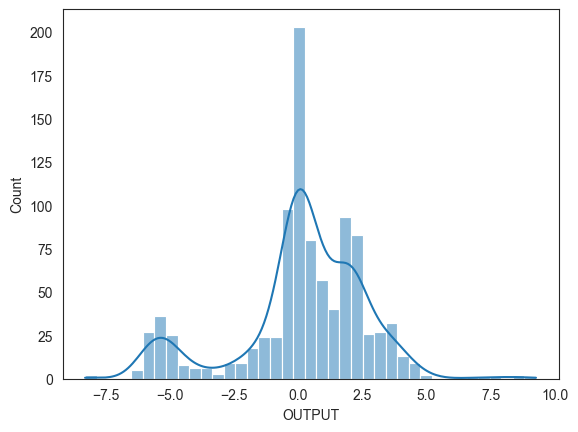

In [35]:
sns.histplot(data['OUTPUT'], kde=True)

In [36]:
data['OUTPUT'].describe()

count    971.000000
mean       0.156567
std        2.511202
min       -8.323000
25%       -0.356000
50%        0.211000
75%        1.915000
max        9.274000
Name: OUTPUT, dtype: float64

In [37]:
# data = data[data['MODE'] != 'REDACTED']
# data.reset_index(drop=True, inplace=True)

## Encoding categorical variables

In [38]:
encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(data[['POWER', 'MODE', 'UNIT']])
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(['POWER', 'MODE', 'UNIT']))

data = pd.concat([data, df_encoded], axis=1)
data = data.drop(['MODE', 'POWER', 'UNIT'], axis=1)
data

,AMPS,VOLTS,TEMP,DELTA,GAMMA,OUTPUT,POWER_high,POWER_low,MODE_REDACTED,MODE_auto,MODE_beam,MODE_burst,UNIT_C,UNIT_K
0,0.585,4.347,66.812,-0.659,-0.527,3.749,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.687,2.412,-17.044,0.508,-0.371,-1.062,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.888,2.979,40.918,0.600,1.412,2.265,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.114,0.754,-43.308,-0.760,-0.109,1.847,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.318,3.955,37.752,-0.751,0.492,1.821,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,0.350,4.257,1.331,0.991,-0.335,2.466,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
967,0.644,1.128,-27.707,-0.529,0.034,-1.834,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
968,0.887,1.418,-71.690,0.729,-0.503,-0.188,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
969,0.323,0.291,-17.162,-0.120,0.524,0.081,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


## Analizing influence of each column

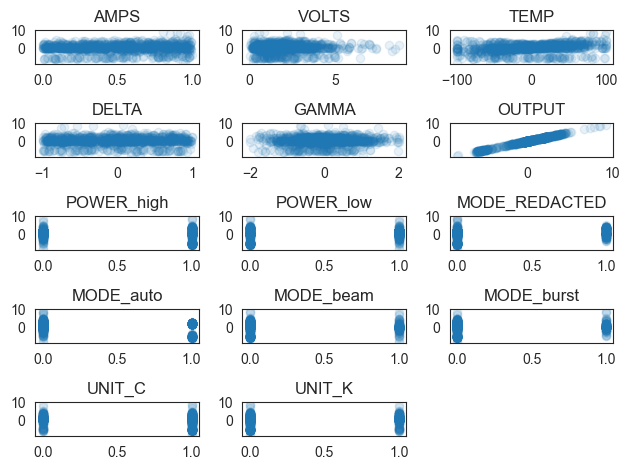

In [39]:
numeric_columns = data.columns
for i, column in enumerate(numeric_columns):
    plt.subplot(5, 3, i + 1)
    plt.scatter(data[column], data['OUTPUT'], alpha=0.1)
    plt.title(column)
    
plt.tight_layout()

<Axes: >

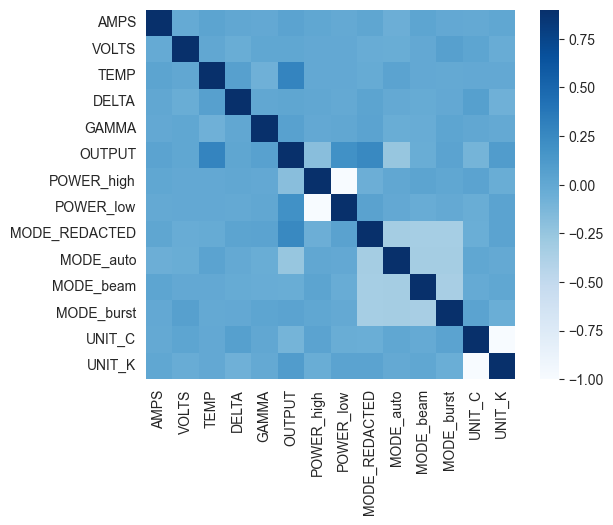

In [40]:
corr = data.corr()
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)


## Testing models

In [41]:
X = data
Y = X['OUTPUT']
X = X.drop('OUTPUT', axis = 1)

kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [42]:
Y.describe()

count    971.000000
mean       0.156567
std        2.511202
min       -8.323000
25%       -0.356000
50%        0.211000
75%        1.915000
max        9.274000
Name: OUTPUT, dtype: float64

In [43]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [44]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
# ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [45]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 1.1360 (0.1611)


In [46]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[14:44:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [47]:
# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

In [48]:
# score = cv_rmse(ridge)
# print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['ridge'] = (score.mean(), score.std())

In [49]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.7475 (0.1480)


In [50]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.9096 (0.1893)


In [51]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, Y)

lightgbm


In [52]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(Y))

stack_gen
[14:55:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cp

In [53]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, Y)

xgboost
[15:00:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
# print('Svr')
# svr_model_full_data = svr.fit(X, Y)

In [55]:
# print('Ridge')
# ridge_model_full_data = ridge.fit(X, Y)

In [56]:
print('RandomForest')
rf_model_full_data = rf.fit(X, Y)

RandomForest


In [57]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, Y)

GradientBoosting


In [58]:
def blended_predictions(X):
    return ((0.1 * gbr_model_full_data.predict(X)) + \
            (0.4 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [59]:
# Get final precitions from the blended model
Y_pred = blended_predictions(X)
blended_score = rmsle(Y, Y_pred)
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.2801965772454485


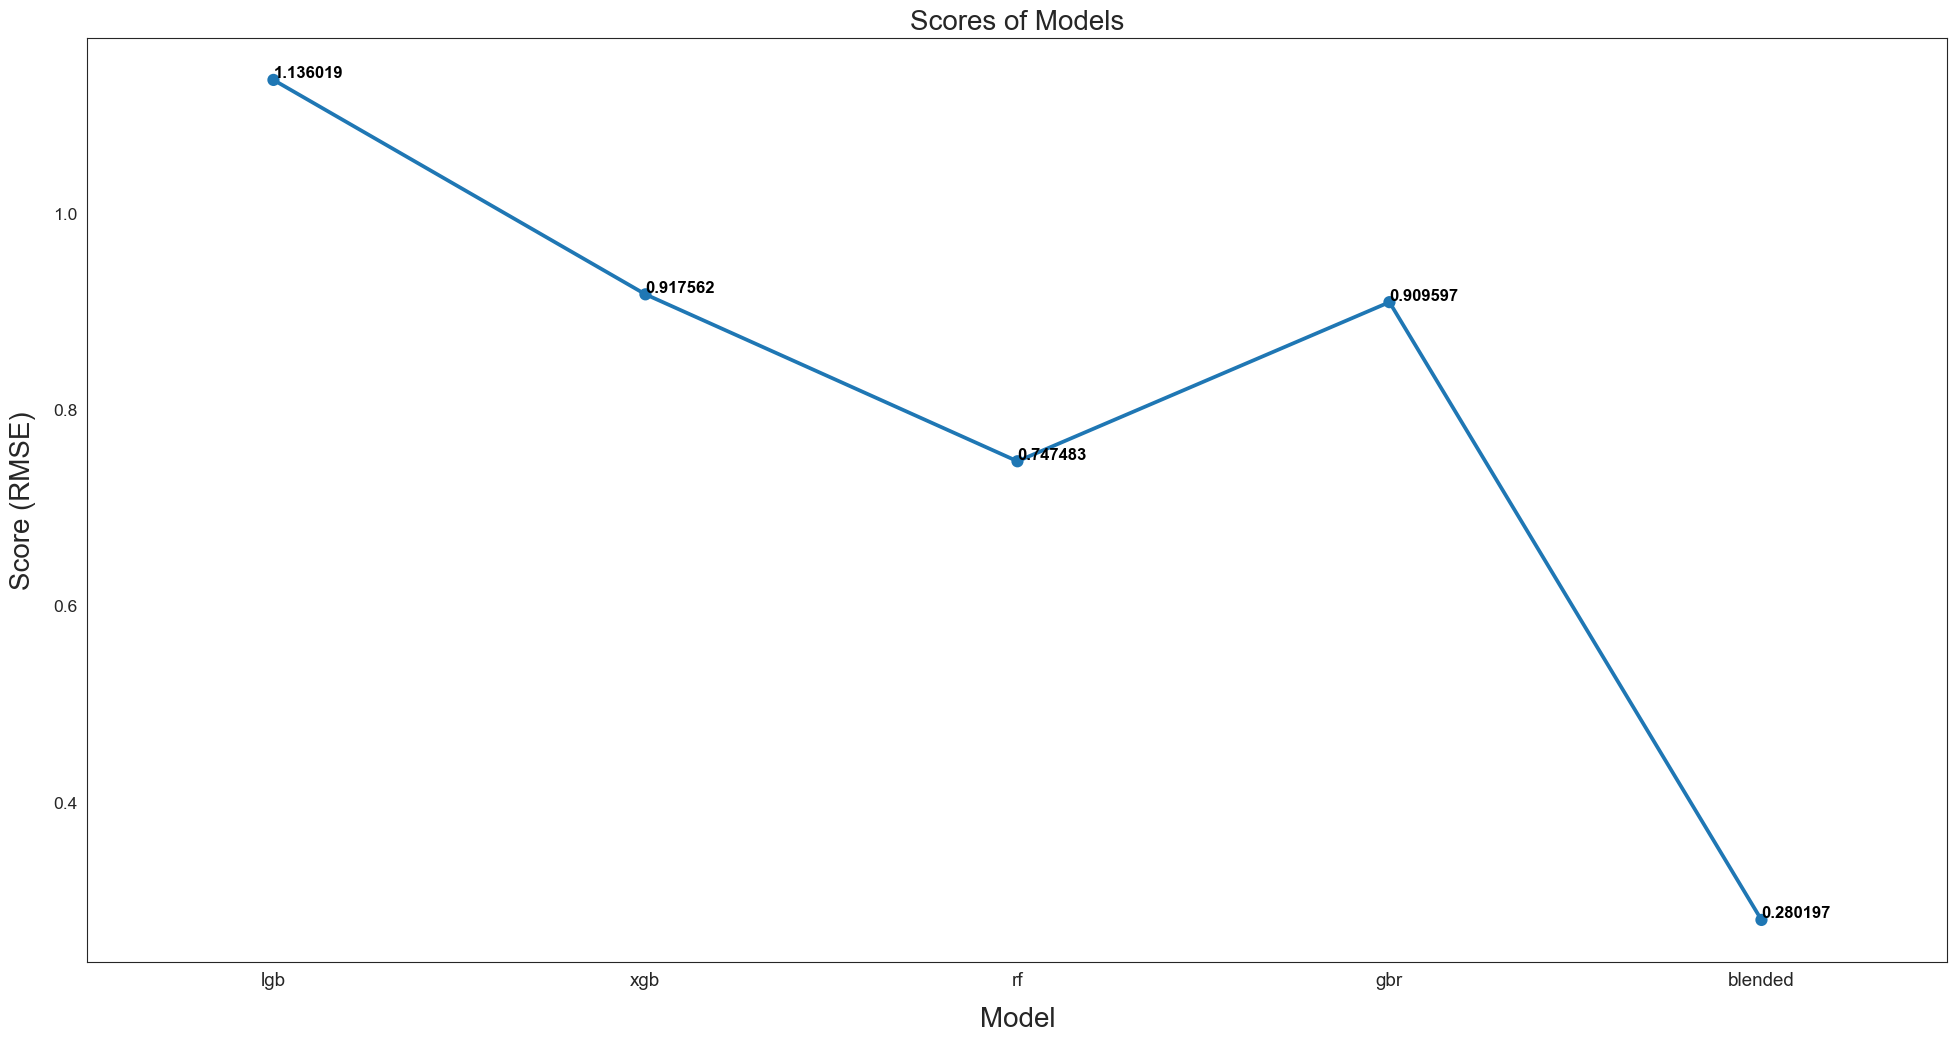

In [60]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [61]:
file_path = "./data/test_data.csv"
df2 = pd.read_csv(file_path)

# Transform the test data using the same encoder instance
encoded_test_data = encoder.transform(df2[['POWER', 'MODE', 'UNIT']])

# Create a new DataFrame with the encoded test data
df_encoded_test  = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names(['POWER', 'MODE', 'UNIT']))
df2 = pd.concat([df2, df_encoded_test], axis=1)

df2 = df2.drop(['MODE', 'POWER', 'UNIT'], axis=1)
Y_pred = blended_predictions(df2)

In [64]:
np.savetxt('./output/output_Blended.csv', Y_pred)